In [18]:
%load_ext autoreload
%autoreload 2

import random
import time

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW

import cpn_model
import config
import michaels_load
import mRNN
import stim_model
import utils 


OBSERVER_TYPE = "gaussian"
STIMULATION_TYPE = "gaussianExp"
CPN_ACTIVATION_TYPE = "Tanh"
EN_ACTIVATION_TYPE = "Tanh"
LESION_TYPE = "connection"
OBS_OUT_DIM = 20
NUM_STIM_CHANNELS = 92
STIM_SIGMA = 0.075
BATCH_SIZE = 128

LESION_ARGS = ([
    # No F5->M1
    (1, 2, 0, 1),
    # No M1->F5
    (0, 1, 1, 2),
],)

observer, stimulus, lesion_instance, en_activation, cpn_activation, recovery_mode, recovery_str, \
        run_type_str, _ = config.get(observer_type=OBSERVER_TYPE,
                                              stimulation_type=STIMULATION_TYPE,
                                              lesion_type=LESION_TYPE,
                                              lesion_args=LESION_ARGS,
                                              en_activation_type=EN_ACTIVATION_TYPE,
                                              cpn_activation_type=CPN_ACTIVATION_TYPE,
                                              batch_size=BATCH_SIZE,
                                              num_stim_channels=NUM_STIM_CHANNELS,
                                              stim_sigma=STIM_SIGMA,
                                              stim_retain_grad=True,
                                              obs_out_dim=OBS_OUT_DIM)


CPN_DATA_DIR = "cpn"
EN_DATA_DIR = "en"
MRNN_DIR = "mrnn"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# Set up the Michaels mRNN

# Our stimulation model
stimulus.reset(batch_size=BATCH_SIZE)

mike = mRNN.MichaelsRNN(init_data_path=michaels_load.get_default_path(),
                       stimulus=stimulus)



In [20]:
# Get the Michaels session data
dataset = mRNN.MichaelsDataset(michaels_load.get_default_path())

# We have two loaders, since they maintain a little bit of state,
# and we nest EN training inside CPN training
loader_cpn = DataLoader(
  dataset, batch_size=BATCH_SIZE, shuffle=True
)

# Loader produces lists of len 2:
#  (input of batch, output of batch); which is:
#  (shape(<=batch_size, time, 21), shape(<=batch_size, time, 50))

torch.Size([341, 21])
torch.Size([1, 341, 50])
torch.Size([1, 341, 50])


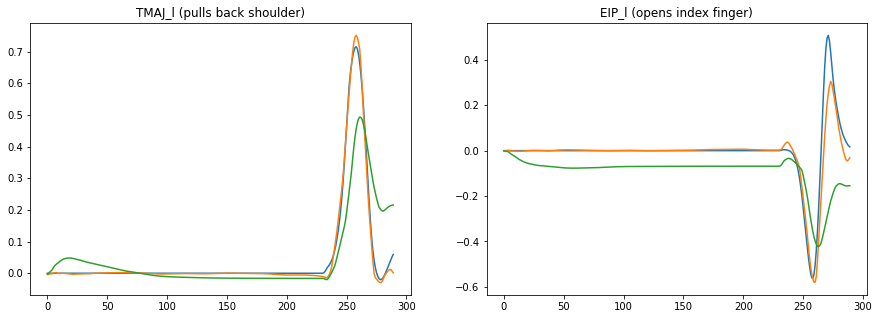

In [21]:
# Just some choice of examples, for graphical comparison
example_idx = random.randrange(len(dataset))
example_din, _, trial_len, example_dout = dataset[example_idx]

mike.set_lesion(None)
mike.reset()
reference_pred_healthy = mike.unroll(example_din.T)

# Lesion the network as we specified above
mike.set_lesion(lesion_instance)
mike.reset()
reference_pred_lesioned = mike.unroll(example_din.T)
mike.reset()


print(example_din.shape)
print(reference_pred_healthy.shape)
print(reference_pred_lesioned.shape)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title("TMAJ_l (pulls back shoulder)")
ax[0].plot(example_dout[:trial_len, 7].detach().numpy())
ax[0].plot(reference_pred_healthy[0, :trial_len, 7].detach().numpy())
ax[0].plot(reference_pred_lesioned[0, :trial_len, 7].detach().numpy())
ax[1].set_title("EIP_l (opens index finger)")
ax[1].plot(example_dout[:trial_len, 45].detach().numpy())
ax[1].plot(reference_pred_healthy[0, :trial_len, 45].detach().numpy())
ax[1].plot(reference_pred_lesioned[0, :trial_len, 45].detach().numpy())

plt.show()

tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0207, grad_fn=<MseLossBackward>)


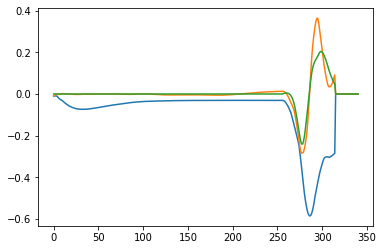

In [22]:
# Now a numerical comparison
comp_loss = torch.nn.MSELoss()

loader_comp = DataLoader(
  dataset, batch_size=len(dataset), shuffle=True
)
for s in loader_comp:
    din, trial_end, _, dout = s

comp_preds_healthy = torch.zeros((len(dataset), dataset.sample_len, reference_pred_healthy.shape[-1]))
mike.set_lesion(None)
mike.reset()
for tidx in range(din.shape[1]):
    cur_din = din[:, tidx, :].T
    p = mike(cur_din)
    comp_preds_healthy[:, tidx, :] = p[:, :]
comp_preds_healthy = utils.trunc_to_trial_end(comp_preds_healthy, trial_end)
comp_loss_healthy = comp_loss(comp_preds_healthy, dout)
print(comp_loss_healthy)

comp_preds_lesioned = torch.zeros((len(dataset), dataset.sample_len, reference_pred_healthy.shape[-1]))
mike.set_lesion(lesion_instance)
mike.reset()
reference_pred_lesioned = mike.unroll(example_din.T)
mike.reset()
for tidx in range(din.shape[1]):
    cur_din = din[:, tidx, :].T
    p = mike(cur_din)
    comp_preds_lesioned[:, tidx, :] = p[:, :]
comp_preds_lesioned = utils.trunc_to_trial_end(comp_preds_lesioned, trial_end)
comp_loss_lesioned = comp_loss(comp_preds_lesioned, dout)
print(comp_loss_lesioned)


plt.plot(comp_preds_lesioned[0, :, 20].detach().numpy())
plt.plot(comp_preds_healthy[0, :, 20].detach().numpy())
plt.plot(dout[0, :, 20].detach().numpy())
plt.show()


In [23]:
def unroll(cpn, mike, din, trial_end, observer,
           drop_module_idx=None, retain_stim_grads=False):
    batch_size = din.shape[0]
    steps = din.shape[1]
    obs_dim = 3 * observer.out_dim
    
    stims = []
    actuals = torch.zeros(batch_size, steps - 1, mike.output_dim)
    
    # This is the actual, which EN predicts
    mike_out = mike(din[:, 0, :].T)
    
    for tidx in range(steps - 1):
        obs = mike.observe(observer, drop_module_idx=drop_module_idx)
        new_obs_cpn = torch.cat(tuple([torch.tensor(o).float() for o in obs]),
                            axis=1)

        # cpn recieves (obs, trial_end)
        cpn_in = torch.cat((new_obs_cpn, trial_end[:, tidx, :]), axis=1)
        # output is (batch_size, num_stim_channels)
        new_stim = cpn(cpn_in)
        assert new_stim.shape == (batch_size, mike.stimulus.num_stim_channels)
        if retain_stim_grads:
            new_stim.retain_grad()
        stims.append(new_stim)
            
        # new_stim will be cloned in here, to prevent accidentally backprop-ing
        # through the "brain", aka mike.
        mike.stimulate(new_stim)
                
        # Note that 'preds' lags 'actual' by a time step, hence
        # 'pred' is a prediction of the actual en activity
        mike_out = mike(din[:, tidx + 1, :].T)
        actuals[:, tidx, :] = mike_out[:, :]
        
    actuals = utils.trunc_to_trial_end(actuals, trial_end[:, :-1, :])
    return actuals, stims 

In [ ]:
obs_dim = observer.out_dim * 3
# +1 for trial_end
cpn_in_dim = obs_dim + 1
#cpn = cpn_model.CPNModelLSTM(cpn_in_dim, mike.stimulus.num_stim_channels,
#                             num_neurons=cpn_in_dim, activation_func=torch.nn.Tanh)


#opt_cpn = AdamW(cpn.parameters(), lr=5e-6)

# Just for zero grad purposes
opt_mrnn = AdamW(mike.parameters())

loss = torch.nn.MSELoss()
rli = 1

cpn_losses = []
real_losses = []
super_epoch_count = 0

eidx = -1
while True:       
    super_epoch_count += 1
    
    recent_losses = []
    num_regressed = 0
    while True:
        for batch in loader_cpn:
            eidx += 1
            opt_cpn.zero_grad()
            opt_mrnn.zero_grad()
            cpn.reset()
            mike.reset()
            
            if rli > 0.02:
                for p in opt_cpn.param_groups:
                    p['lr'] = 1e-4
            elif rli <= 0.015:
                for p in opt_cpn.param_groups:
                    #p['lr'] = 1e-5
                    p['lr'] = 1e-4
            elif rli <= 0.0125:
                for p in opt_cpn.param_groups:
                    p['lr'] = 5e-6
            elif rli <= 0.01:
                for p in opt_cpn.param_groups:
                    p['lr'] = 1e-7
            
            din, trial_end, trial_len, dout = batch
            batch_size = din.shape[0]
            steps = din.shape[1]
    
            actuals, stims = unroll(cpn, mike, din, trial_end, observer,
                                           retain_stim_grads=True)
            
            rl = loss(actuals, dout[:, 1:, :])
            rli = rl.item()
            rl.backward()  
            
            print("cpn", eidx, rl.item())
            recent_losses.append(rli)
            
            torch.save(cpn.state_dict(), "latest_cpn_F5condrop_obs20_stim92_nn150_noen")
            if rli == min(recent_losses) and rli < 0.01:
                torch.save(cpn.state_dict(), "min_cpn_F5condrop_obs20_stim92_nn150_noen")
                                                          
            bail = False
            done = False
            # Done
            if rli < 5e-5:
                bail = True
                done = True
                break
                
            opt_cpn.step()
                
            if bail:
                break
                
        if bail:
            break
            
    if done:
        break

cpn 0 0.0021433518268167973
cpn 1 0.002112052869051695
cpn 2 0.0022134054452180862
cpn 3 0.0021099853329360485
cpn 4 0.0021865880116820335
cpn 5 0.0021086684428155422
cpn 6 0.0020497010555118322
cpn 7 0.0022143544629216194
cpn 8 0.0022260837722569704
cpn 9 0.0020550289191305637
cpn 10 0.0021591694094240665
cpn 11 0.0020875155460089445
cpn 12 0.0021653620060533285
cpn 13 0.002042685868218541
cpn 14 0.002233167877420783
cpn 15 0.002065169159322977
cpn 16 0.002142207929864526
cpn 17 0.0021422042045742273
cpn 18 0.002205918077379465
cpn 19 0.002006102818995714
cpn 20 0.0020623954478651285
cpn 21 0.002100905869156122
cpn 22 0.002193896798416972
cpn 23 0.0021225681994110346
cpn 24 0.002133126137778163
cpn 25 0.002056615659967065
cpn 26 0.0020904510747641325
cpn 27 0.002188377548009157
cpn 28 0.002064158907160163
cpn 29 0.0021221700590103865
cpn 30 0.00214556185528636
cpn 31 0.0021164389327168465
cpn 32 0.00208606687374413
cpn 33 0.002094244584441185
cpn 34 0.0021358435042202473
cpn 35 0.0021

cpn 282 0.0019736792892217636
cpn 283 0.0019105091923847795
cpn 284 0.0019110924331471324
cpn 285 0.0018687790725380182
cpn 286 0.001898841466754675
cpn 287 0.0019514481537044048
cpn 288 0.0019623995758593082
cpn 289 0.0018479382852092385
cpn 290 0.001943243551068008
cpn 291 0.0018965174676850438
cpn 292 0.0018986026989296079
cpn 293 0.001956020016223192
cpn 294 0.0017932099290192127
cpn 295 0.0019576968625187874
cpn 296 0.0019678601529449224
cpn 297 0.0018826040904968977
cpn 298 0.0019055474549531937
cpn 299 0.0018208319088444114
cpn 300 0.0018578525632619858
cpn 301 0.0018743457039818168
cpn 302 0.0019451504340395331
cpn 303 0.0018859101692214608
cpn 304 0.0018632040591910481
cpn 305 0.0018854992231354117
cpn 306 0.001856879098340869
cpn 307 0.0019502787617966533
cpn 308 0.0018458606209605932
cpn 309 0.0018170736730098724
cpn 310 0.001903500291518867
cpn 311 0.0019766062032431364
cpn 312 0.001922314870171249
cpn 313 0.001788695459254086
cpn 314 0.0018905765609815717
cpn 315 0.0019525

cpn 558 0.001778713776730001
cpn 559 0.0017455167835578322
cpn 560 0.0017958719981834292
cpn 561 0.001745878835208714
cpn 562 0.0018097100546583533
cpn 563 0.0016970388824120164
cpn 564 0.0017586040776222944
cpn 565 0.0017944267019629478
cpn 566 0.0017825866816565394
cpn 567 0.0017301685875281692
cpn 568 0.0017512290505692363
cpn 569 0.0018004733137786388
cpn 570 0.0017347686225548387
cpn 571 0.0017820149660110474
cpn 572 0.0017981462879106402
cpn 573 0.0017322333296760917
cpn 574 0.0018080375157296658
cpn 575 0.0018006986938416958
cpn 576 0.0018295651534572244
cpn 577 0.0017713665729388595
cpn 578 0.001750574796460569
cpn 579 0.0016852847766131163
cpn 580 0.0017591804498806596
cpn 581 0.0018039315473288298
cpn 582 0.0017379014752805233
cpn 583 0.001715534832328558
cpn 584 0.0017007903661578894
cpn 585 0.0017755442531779408
cpn 586 0.0017596529796719551
cpn 587 0.0017654524417594075
cpn 588 0.0017748577520251274
cpn 589 0.0017670992529019713
cpn 590 0.0017366715474054217
cpn 591 0.0017

cpn 833 0.0016060363268479705
cpn 834 0.0017038544174283743
cpn 835 0.0016120194923132658
cpn 836 0.0015783639391884208
cpn 837 0.0017231927486136556
cpn 838 0.0016187363071367145
cpn 839 0.0016652568010613322
cpn 840 0.0016304068267345428
cpn 841 0.0016225503059104085
cpn 842 0.0016079855849966407
cpn 843 0.0017057881923392415
cpn 844 0.0017061473336070776
cpn 845 0.0016688607865944505
cpn 846 0.0015873064985498786
cpn 847 0.0015920717269182205
cpn 848 0.0015707641141489148
cpn 849 0.001738088671118021
cpn 850 0.0016093971207737923
cpn 851 0.0016395035199820995
cpn 852 0.001649245503358543
cpn 853 0.0016413058619946241
cpn 854 0.0016529216663911939
cpn 855 0.0015857585240155458
cpn 856 0.0016281616408377886
cpn 857 0.0016215291107073426
cpn 858 0.0016279019182547927
cpn 859 0.0016475034644827247
cpn 860 0.0016255920054391026
cpn 861 0.0016923468792811036
cpn 862 0.0016502670478075743
cpn 863 0.0015718091744929552
cpn 864 0.0016545522958040237
cpn 865 0.0016169699374586344
cpn 866 0.00

cpn 1105 0.0015260007930919528
cpn 1106 0.0015326000284403563
cpn 1107 0.00156996154692024
cpn 1108 0.0015264283865690231
cpn 1109 0.001526690786704421
cpn 1110 0.0015516969142481685
cpn 1111 0.0015675709582865238
cpn 1112 0.001566405757330358
cpn 1113 0.0016279355622828007
cpn 1114 0.0014647607458755374
cpn 1115 0.0015149102546274662
cpn 1116 0.0015584311913698912
cpn 1117 0.0014789742417633533
cpn 1118 0.0015684394165873528
cpn 1119 0.0015800104010850191
cpn 1120 0.0015316035132855177
cpn 1121 0.001598613802343607
cpn 1122 0.001485923188738525
cpn 1123 0.001590120722539723
cpn 1124 0.0015825070440769196
cpn 1125 0.0015481424052268267
cpn 1126 0.0015730427112430334
cpn 1127 0.0014690504176542163
cpn 1128 0.0015530174132436514
cpn 1129 0.0015096161514520645
cpn 1130 0.001499375095590949
cpn 1131 0.0015882946318015456
cpn 1132 0.0016175528289750218
cpn 1133 0.0014725737273693085
cpn 1134 0.0015163600910454988
cpn 1135 0.001545242266729474
cpn 1136 0.001535845804028213
cpn 1137 0.0015537

cpn 1372 0.001454449724406004
cpn 1373 0.0015629687113687396
cpn 1374 0.0014457113575190306
cpn 1375 0.001430416596122086
cpn 1376 0.0015123661141842604
cpn 1377 0.0014279934111982584
cpn 1378 0.0015022041043266654
cpn 1379 0.001477144076488912
cpn 1380 0.0015392606146633625
cpn 1381 0.0015056433621793985
cpn 1382 0.0014056814834475517
cpn 1383 0.0014464930864050984
cpn 1384 0.001498523517511785
cpn 1385 0.0015210236888378859
cpn 1386 0.0014575393870472908
cpn 1387 0.0013516618637368083
cpn 1388 0.0015333803603425622
cpn 1389 0.0014579405542463064
cpn 1390 0.0014615372056141496
cpn 1391 0.0015083793550729752
cpn 1392 0.0013970551081001759
cpn 1393 0.001485389773733914
cpn 1394 0.0014532293425872922
cpn 1395 0.0014751121634617448
cpn 1396 0.0014028784353286028
cpn 1397 0.0014483884442597628
cpn 1398 0.0014853739412501454
cpn 1399 0.0014930317411199212
cpn 1400 0.001427742070518434
cpn 1401 0.0014650995144620538
cpn 1402 0.0014520259574055672
cpn 1403 0.0014122750144451857
cpn 1404 0.001

cpn 1639 0.0013179578818380833
cpn 1640 0.0014129583723843098
cpn 1641 0.0012934866826981306
cpn 1642 0.0013711689971387386
cpn 1643 0.001384920091368258
cpn 1644 0.0014250812819227576
cpn 1645 0.001380199915729463
cpn 1646 0.0013969681458547711
cpn 1647 0.0013153007021173835
cpn 1648 0.0014354363083839417
cpn 1649 0.0013180493842810392
cpn 1650 0.0013444318901747465
cpn 1651 0.0013479660265147686
cpn 1652 0.001387941767461598
cpn 1653 0.0013622979167848825
cpn 1654 0.0013330642832443118
cpn 1655 0.00133709073998034
cpn 1656 0.0013119734358042479
cpn 1657 0.0014006986748427153
cpn 1658 0.0013800770975649357
cpn 1659 0.0013264169683679938
cpn 1660 0.0014186372281983495
cpn 1661 0.0013426082441583276
cpn 1662 0.001337479567155242
cpn 1663 0.0013461813796311617
cpn 1664 0.001318864757195115
cpn 1665 0.0014230008237063885
cpn 1666 0.0013075185706838965
cpn 1667 0.0013622093247249722
cpn 1668 0.0013226569863036275
cpn 1669 0.0013430541148409247
cpn 1670 0.0014179758727550507
cpn 1671 0.0013

cpn 1906 0.0013618542579934
cpn 1907 0.0012903701281175017
cpn 1908 0.0013895579613745213
cpn 1909 0.001311951200477779
cpn 1910 0.001298125134781003
cpn 1911 0.0013079941272735596
cpn 1912 0.0012553832493722439
cpn 1913 0.0012656477047130466
cpn 1914 0.0013297336408868432
cpn 1915 0.0012940306914970279
cpn 1916 0.001337301917374134
cpn 1917 0.0012595606967806816
cpn 1918 0.0013914030278101563
cpn 1919 0.001233485178090632
cpn 1920 0.001313796266913414
cpn 1921 0.0012543796328827739
cpn 1922 0.0013133407337591052
cpn 1923 0.0013256784295663238
cpn 1924 0.0013137890491634607
cpn 1925 0.0012910867808386683
cpn 1926 0.001392941689118743
cpn 1927 0.0012706383131444454
cpn 1928 0.0012801927514374256
cpn 1929 0.0013111337320879102
cpn 1930 0.0012758394004777074
cpn 1931 0.0013607164146378636
cpn 1932 0.0012731743045151234
cpn 1933 0.001313703483901918
cpn 1934 0.0012848196784034371
cpn 1935 0.0012756407959386706
cpn 1936 0.0012592317070811987
cpn 1937 0.0013246913440525532
cpn 1938 0.0012786

cpn 2173 0.0013391409302130342
cpn 2174 0.0012963282642886043
cpn 2175 0.001299730152823031
cpn 2176 0.0012844743905588984
cpn 2177 0.0012198782060295343
cpn 2178 0.0014269605744630098
cpn 2179 0.0012344059068709612
cpn 2180 0.0013102514203637838
cpn 2181 0.0012319657253101468
cpn 2182 0.0012042911257594824
cpn 2183 0.0012764508137479424
cpn 2184 0.0012656492181122303
cpn 2185 0.0012725485721603036
cpn 2186 0.0012795368675142527
cpn 2187 0.0011760067427530885
cpn 2188 0.0011957819806411862
cpn 2189 0.0012265543919056654
cpn 2190 0.0012798096286132932
cpn 2191 0.0012243627570569515
cpn 2192 0.0011911223409697413
cpn 2193 0.001247610547579825
cpn 2194 0.0012506917119026184
cpn 2195 0.0012268603313714266
cpn 2196 0.0013016784796491265
cpn 2197 0.0012274495093151927
cpn 2198 0.0012063137255609035
cpn 2199 0.0012165732914581895
cpn 2200 0.0011998460395261645
cpn 2201 0.0012840516865253448
cpn 2202 0.0012208601692691445
cpn 2203 0.0013454209547489882
cpn 2204 0.0012072287499904633
cpn 2205 0

cpn 2440 0.0011915902141481638
cpn 2441 0.001211783499456942
cpn 2442 0.001193591975606978
cpn 2443 0.0011945647420361638
cpn 2444 0.001206273678690195
cpn 2445 0.0011741998605430126
cpn 2446 0.001148885115981102
cpn 2447 0.0012467660708352923
cpn 2448 0.001196632394567132
cpn 2449 0.0012103779008612037
cpn 2450 0.0011678097071126103
cpn 2451 0.0011822324013337493
cpn 2452 0.0012116733705624938
cpn 2453 0.0012484908802434802
cpn 2454 0.0012076289858669043
cpn 2455 0.0011498124804347754
cpn 2456 0.0011838470818474889
cpn 2457 0.0011955790687352419
cpn 2458 0.0012513069668784738
cpn 2459 0.0012428776826709509
cpn 2460 0.0012373423669487238
cpn 2461 0.0011828980641439557
cpn 2462 0.0011490931501612067
cpn 2463 0.0012089799856767058
cpn 2464 0.0013000932522118092
cpn 2465 0.0012390193296596408
cpn 2466 0.0011683430057018995
cpn 2467 0.0011477632215246558
cpn 2468 0.0011535893427208066
cpn 2469 0.001267042476683855
cpn 2470 0.0012196869356557727
cpn 2471 0.0014522126875817776
cpn 2472 0.001

cpn 2707 0.0011434325715526938
cpn 2708 0.001146801863797009
cpn 2709 0.0011787072289735079
cpn 2710 0.0012030135840177536
cpn 2711 0.0012629983248189092
cpn 2712 0.001169174094684422
cpn 2713 0.0012618034379556775
cpn 2714 0.0011339959455654025
cpn 2715 0.001202992396429181
cpn 2716 0.0011741346679627895
cpn 2717 0.0011443875264376402
cpn 2718 0.001146852970123291
cpn 2719 0.0011476416839286685
cpn 2720 0.0011112139327451587
cpn 2721 0.0011957773240283132
cpn 2722 0.0011447010328993201
cpn 2723 0.0011157938279211521
cpn 2724 0.0011016716016456485
cpn 2725 0.001127622788771987
cpn 2726 0.0011749553959816694
cpn 2727 0.001163134234957397
cpn 2728 0.001109074684791267
cpn 2729 0.0011934807989746332
cpn 2730 0.001130443997681141
cpn 2731 0.0011367140104994178
cpn 2732 0.0011486231815069914
cpn 2733 0.0011285186046734452
cpn 2734 0.0011880227830260992
cpn 2735 0.001106044976040721
cpn 2736 0.0011671569664031267
cpn 2737 0.0011273837881162763
cpn 2738 0.0011381773510947824
cpn 2739 0.001186

cpn 2974 0.001086179749108851
cpn 2975 0.0012002532603219151
cpn 2976 0.001080875750631094
cpn 2977 0.0011833111057057977
cpn 2978 0.0011779428459703922
cpn 2979 0.0011085453443229198
cpn 2980 0.0012215272290632129
cpn 2981 0.00108825764618814
cpn 2982 0.0012537168804556131
cpn 2983 0.0010317339329048991
cpn 2984 0.0013001663610339165
cpn 2985 0.0010771263623610139
cpn 2986 0.0012007668847218156
cpn 2987 0.0011512887431308627
cpn 2988 0.0010960178915411234
cpn 2989 0.001118744956329465
cpn 2990 0.0011300643673166633
cpn 2991 0.0011544071603566408
cpn 2992 0.001071079634130001
cpn 2993 0.0011247774818912148
cpn 2994 0.0011755231535062194
cpn 2995 0.0010941213695332408
cpn 2996 0.0010997222270816565
cpn 2997 0.0011534448713064194
cpn 2998 0.0011382184457033873
cpn 2999 0.0011216928251087666
cpn 3000 0.0010863603092730045
cpn 3001 0.001178205944597721
cpn 3002 0.0010849711252376437
cpn 3003 0.0011220095911994576
cpn 3004 0.001153451856225729
cpn 3005 0.0010993750765919685
cpn 3006 0.00112

cpn 3241 0.0011701680487021804
cpn 3242 0.0011555745732039213
cpn 3243 0.0011345542734488845
cpn 3244 0.001149984891526401
cpn 3245 0.0010599466040730476
cpn 3246 0.0011521648848429322
cpn 3247 0.0011117005487903953
cpn 3248 0.0011168053606525064
cpn 3249 0.00106510566547513
cpn 3250 0.0010865756776183844
cpn 3251 0.001197510282509029
cpn 3252 0.0010871620615944266
cpn 3253 0.0011203120229765773
cpn 3254 0.0011336531024426222
cpn 3255 0.001181223546154797
cpn 3256 0.0011589060304686427
cpn 3257 0.0011477268999442458
cpn 3258 0.0010795918060466647
cpn 3259 0.00118451367598027
cpn 3260 0.001002335688099265
cpn 3261 0.0011250064708292484
cpn 3262 0.0011469771852716804
cpn 3263 0.0010622129775583744
cpn 3264 0.0010635341750457883
cpn 3265 0.0010529446881264448
cpn 3266 0.001093079918064177
cpn 3267 0.00111620151437819
cpn 3268 0.0010185007704421878
cpn 3269 0.0010727493790909648
cpn 3270 0.0011002817191183567
cpn 3271 0.001132809091359377
cpn 3272 0.0010940306819975376
cpn 3273 0.001112588

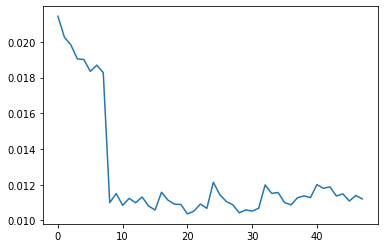

0.010367924347519875


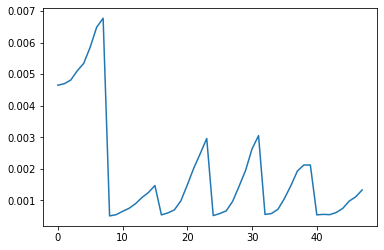

0.0005120153073221445


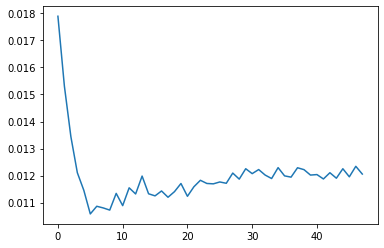

0.010581720620393753
0.5031849260026771 tensor(0.0207, grad_fn=<MseLossBackward>) tensor(0.0006, grad_fn=<MseLossBackward>)


In [25]:
plt.plot(cpn_losses)
plt.show()
print(min(cpn_losses))

plt.plot(pred_losses)
plt.show()
print(min(pred_losses))

plt.plot(real_losses)
plt.show()
print(min(real_losses))

mrl = min(real_losses)
dh = mrl - comp_loss_healthy.item()
dl = comp_loss_lesioned.item() - comp_loss_healthy.item()
recov_pct = 1.0 - (dh / dl)
print(recov_pct, comp_loss_lesioned, comp_loss_healthy)

In [26]:
# TODO: get a CPN collection and explore the impact of the level of noise we are using.
# TODO: look for classes or data points we suck at
# TODO: train vs test
# TODO: deep dive EN grads bad

print(recent_losses)

[0.012536630965769291, 0.012541639618575573]


torch.Size([1, 341, 50])


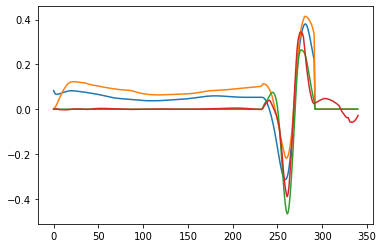

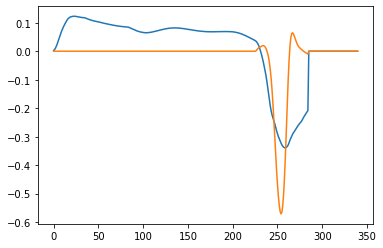

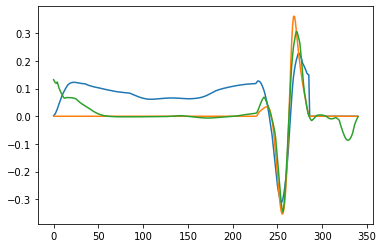

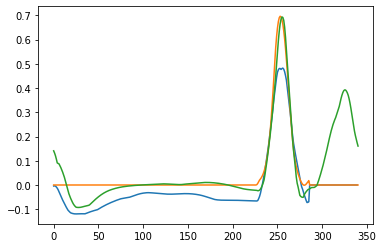

In [27]:
mike.reset()
reference_pred_lesioned_0 = mike.unroll(din[0, :, :].T)
reference_pred_lesioned_neg1 = mike.unroll(din[-1, :, :].T)
reference_pred_lesioned_20 = mike.unroll(din[20, :, :].T)
mike.reset()

print(reference_pred_lesioned_0.shape)


plt.plot(preds[0, :, 45].detach().numpy())
#plt.plot(preds.grad[0, :, 45].detach().numpy())
plt.plot(actuals[0, :, 45].detach().numpy())
plt.plot(dout[0, :, 45].detach().numpy())
plt.plot(reference_pred_lesioned_0[0, :, 45].detach().numpy())
plt.show()

#plt.plot(preds[-1, :, 45].detach().numpy())
plt.plot(actuals[-1, :, 45].detach().numpy())
plt.plot(dout[-1, :, 45].detach().numpy())
plt.show()

#plt.plot(preds[20, :, 45].detach().numpy())
plt.plot(actuals[20, :, 45].detach().numpy())
plt.plot(dout[20, :, 45].detach().numpy())
plt.plot(reference_pred_lesioned_20[0, :, 45].detach().numpy())
plt.show()

#plt.plot(preds[20, :, 7].detach().numpy())
plt.plot(actuals[20, :, 7].detach().numpy())
plt.plot(dout[20, :, 7].detach().numpy())
plt.plot(reference_pred_lesioned_20[0, :, 7].detach().numpy())
plt.show()

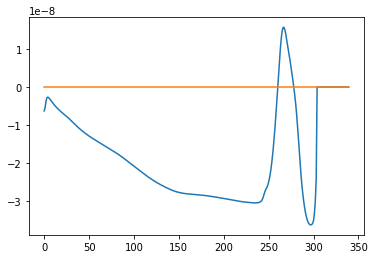

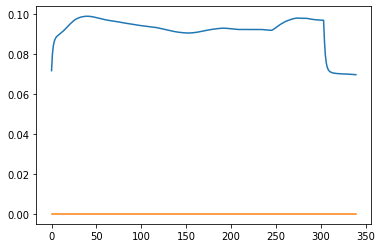

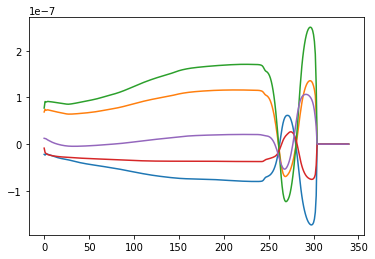

In [44]:
ss = [x[20, 6].item() for x in stims]
gg = [x.grad[20, 6].item() for x in stims]
ref = [0.0 for x in stims]

plt.plot(gg)
plt.plot(ref)
plt.show()
plt.plot(ss)
plt.plot(ref)
plt.show()

for idx in range(0, 25, 5):
    gg = [x.grad[20, idx].item() for x in stims]
    plt.plot(gg)
plt.show()

# On bad run: gradient is negative when values are too high

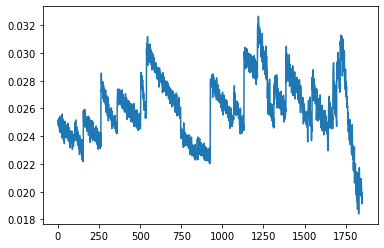

In [12]:
plt.plot(cpn_losses)